In [8]:
import numpy as np

from functools import partial, reduce
from itertools import accumulate, repeat, chain, takewhile, tee, islice
import random

import more_itertools

In [9]:
def initialize_weights_and_biases(num_nodes, mode=np.random.random):
    return np.array([
                  (mode((m,n))/(n*m), np.zeros(m))
                  for n, m in zip(num_nodes[:-1], num_nodes[1:])])

def affine(weights_and_biases_pair, x):
    return weights_and_biases_pair[0]@x + weights_and_biases_pair[1]
    
def network_eval(weights_and_biases, x, f=np.tanh):
    if len(weights_and_biases) == 0:
        return x
    else:
        layer_output = f(affine(weights_and_biases[0],x))
        return network_eval(weights_and_biases[1:], 
                            layer_output, f=f)
    
def quadratic_cost_derivative(a, y):
    return a-y

def cross_entropy_cost_derivative(a, y):
    return (a-y)/(a * (1-a))

def nn_gradient_recursion(weights_and_biases, a, y, f, df, cost_derivative=quadratic_cost_derivative):
    if len(weights_and_biases) == 0:
        return cost_derivative(a,y), ()
    
    z = affine(weights_and_biases[0], a)
    
    grad_a, grad_list = nn_gradient_recursion(
                               weights_and_biases[1:], 
                               f(z), 
                               y, 
                               f=f, 
                               df=df)
    delta = grad_a * df(z)
    my_grad = (np.outer(delta, a), delta)
    return (weights_and_biases[0][0].T@delta, (my_grad,) + grad_list)

def nn_gradient_sample(weights_and_biases, a, y, f=np.tanh, df=lambda x: 1/np.cosh(x)**2, cost_derivative=quadratic_cost_derivative):
    return nn_gradient_recursion(weights_and_biases, a, y, f=f, df=df, cost_derivative=cost_derivative)[1]
    
def nn_gradient(weights_and_biases, input_data, cost_derivative=quadratic_cost_derivative):
    return sum(np.array(nn_gradient_sample(weights_and_biases, *data)) 
               for data in input_data)/len(input_data)

def nn_gradient_descent_sequence(params0, data, learning_rate=0.01, cost_derivative=quadratic_cost_derivative):
    def param_improve(params):
        return params - learning_rate*nn_gradient(params, data, cost_derivative=cost_derivative)
    return iterate_seq(params0, param_improve)

def error(weights, x, y):
    return np.sum( (network_eval(weights,x) - y)**2 )

In [120]:
# def iterate_seq(x0, update):
#     x = x0
#     yield x
#     while True:
#         x = update(x)
#         yield x

def iterate_seq(x0, update):
    apply = lambda x, f: f(x)
    return accumulate(
            chain((x0,), repeat(update)),
            apply
    )

def newton_sequence(x0, f, df):
    def newton_improve(x):
        return x - f(x)/df(x)
    return iterate_seq(x0, newton_improve)

# def filter_cauchy_tol(difference_function = lambda x1, x2: abs(x1 - x2), tol=1e-10):
#     def my_filter(iterable):
#         x1 = next(iterable)
#         yield x1
#         x2 = next(iterable)
#         while( difference_function(x1, x2) > tol ):
#             x1, x2 = x2, next(iterable)
#             yield x2
#     return my_filter

def filter_cauchy_tol(difference_function = lambda x1, x2: abs(x1 - x2), tol=1e-10):
    predicate = lambda tup: difference_function(*tup) > tol
    def my_filter(iterable):
        copy1, copy2 = tee(iterable)
        x0 = next(copy2)
        filtered_pairs = takewhile(predicate, zip(copy1, copy2))
        filtered_vals = map(lambda tup: tup[1], filtered_pairs)
        return chain((x0,), filtered_vals)
    return my_filter
    
# def filter_f_tol(f, tol=1e-10):
#     def my_filter(iterable):
#         x = next(iterable)
#         yield x
#         while f(x) > tol:
#             x = next(iterable)
#             yield x
#     return my_filter

def filter_f_tol(f, tol=1e-10):
    predicate = lambda x: abs(f(x) > tol)
    return partial(takewhile, predicate)
        
def batch_error(weights, data):
    return sum( error(weights, *d) for d in data )/len(data)

def filter_max_iter(max_iter=10**3):
    my_filter = lambda iterable: islice(iterable, 0, max_iter)
    return my_filter

def pipeline_eval(x, *func_list):
    def apply(x, f):
        return f(x)
    return reduce(apply, func_list, x)

def data_shuffler_generator(data):
    while True:
        random.shuffle(data)
        yield from data
        
def nn_stochastic_gradient_descent_sequence(params0, batch_stream, learning_rate=0.01, cost_derivative=quadratic_cost_derivative):
    def param_improve(params):
        batch = next(batch_stream)
        return params - learning_rate*nn_gradient(params, batch, cost_derivative=cost_derivative)
    return iterate_seq(params0, param_improve)

def batch_error(data, weights):
    return sum( error(weights, *d) for d in data )/len(data)

batch_generator = more_itertools.chunked

In [142]:
W0_B0 = initialize_weights_and_biases((2, 4, 1))
data_xor = (
    (np.array([0, 0]), np.array([0])),
    (np.array([1, 0]), np.array([1])),
    (np.array([0, 1]), np.array([1])),
    (np.array([1, 1]), np.array([0]))
)

In [143]:
weights = W0_B0
learning_rate = 0.3
# learning_rate = .0000005

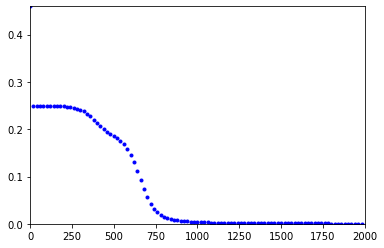

In [144]:
gd_sequence = nn_gradient_descent_sequence(weights, data_xor, learning_rate = learning_rate, cost_derivative=cross_entropy_cost_derivative)

%matplotlib inline
import time
from IPython import display
import matplotlib.pyplot as plt
stride = 20
max_iter = 2000
y_max = 1
for i, weights in enumerate(
                    islice(
                        gd_sequence,
                        0, max_iter, stride)):
    e = batch_error(data_xor, weights)
    if i == 0:
        y_max = e
    #plt.clf()
    plt.plot(i*stride, e, 'b.')
    plt.xlim(0, max_iter)
    plt.ylim(0, y_max)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
weights = next(gd_sequence)

In [148]:
errors = pipeline_eval(
    nn_gradient_descent_sequence(W0_B0, 
                                 data_xor, 
                                 learning_rate = learning_rate, 
                                 cost_derivative=cross_entropy_cost_derivative),
    filter_max_iter(2000),
    partial(map,
            partial(batch_error, data_xor)),
    list)

In [154]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

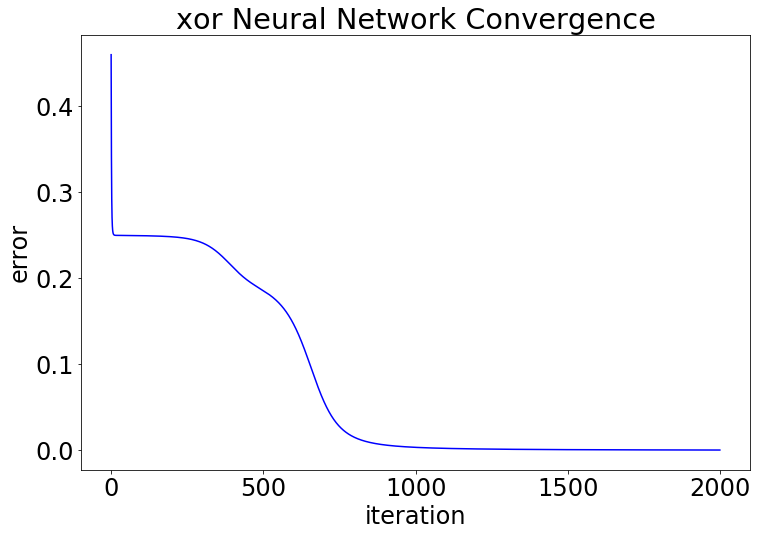

In [163]:
plt.figure(figsize=(12, 8))
plt.plot(errors, 'b-')
plt.ylabel('error')
plt.xlabel('iteration')
plt.xticks([i for i in range(0, len(errors)+1, 500)])
plt.title('xor Neural Network Convergence')
plt.savefig('xor_nn_convergence.svg')

In [14]:
for x, y in data_xor:
    y_hat = network_eval(weights, x)
    print(f'x = {x}\t y = {y}\t output={y_hat}\t error={y_hat-y}')

x = [0 0]	 y = [0]	 output=[0.00142572]	 error=[0.00142572]
x = [1 0]	 y = [1]	 output=[0.97030578]	 error=[-0.02969422]
x = [0 1]	 y = [1]	 output=[0.97035425]	 error=[-0.02964575]
x = [1 1]	 y = [0]	 output=[0.00242435]	 error=[0.00242435]


# MNIST

In [37]:
import struct
import pickle
import numpy as np
import matplotlib.pyplot as plt

def read_MNIST_labels(file_path, max_records = None):
    with open(file_path, 'rb') as file:
        labels = []
        magic_word = file.read(4)
        total_label_records = struct.unpack('>i',file.read(4))[0]
        if not max_records == None:
            total_label_records = min(total_label_records,max_records[0])
        for i in range(total_label_records):
            labels.append(struct.unpack('B',file.read(1))[0])
    return labels

def read_MNIST_images(file_path, max_records = None):
    with open(file_path,'rb') as file:
        images = []
        magic_word = file.read(4)
        total_image_records = struct.unpack('>i',file.read(4))[0]
        row_size = struct.unpack('>i',file.read(4))[0]
        col_size = struct.unpack('>i',file.read(4))[0]
        if not max_records == None:
            total_image_records = min(total_image_records,max_records[0])
        for _ in range(total_image_records):
            image = []
            for _ in range(row_size*col_size):
                image.append(struct.unpack('B',file.read(1))[0] / 255)
            images.append(np.array(image))
            
    return images
    
def format_labels(labels):
    expected = []
    for i in range(len(labels)):
        l = [0] * 10
        l[labels[i]] = 1
        expected.append(l)
    return expected

def print_image(img):
    for r in range(28):
        for c in range(28):
            str = " "
            if img[r*28+c] > 150: str = 'x'
            print(str,end='')
        print('')
        
def one_hot_encode(label):
    ret = np.zeros(10)
    ret[label] = 1
    return ret

def one_hot_decode(label):
    return int(np.argmax(label))
        
plot_image = lambda img: plt.imshow(img.reshape(28, 28) / 255, cmap = 'Greys')

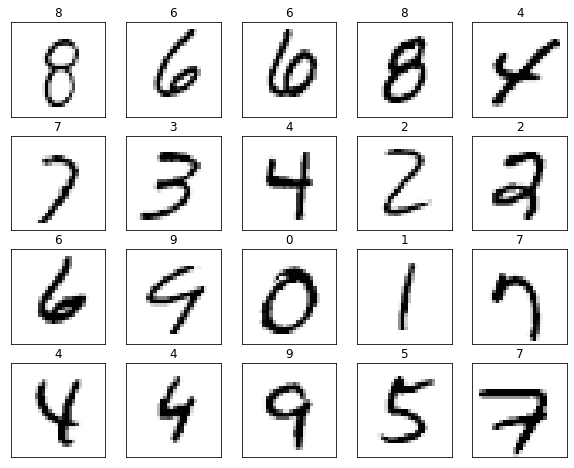

In [38]:
num_records = None

MNIST_data = list(zip(
    read_MNIST_images('MNIST/train-images.idx3-ubyte', num_records),
    [one_hot_encode(label) for label in read_MNIST_labels('MNIST/train-labels.idx1-ubyte', num_records)]
))

MNIST_test_data = list(zip(
    read_MNIST_images('MNIST/t10k-images.idx3-ubyte'),
    [one_hot_encode(label) for label in read_MNIST_labels('MNIST/t10k-labels.idx1-ubyte')]
))

def data_shuffler_generator(data):
    while True:
        random.shuffle(data)
        yield from data
        
MNIST_data_stream = data_shuffler_generator(MNIST_data)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, (image, label) in zip(axes.flatten(), MNIST_data_stream):
    #plot_image(image)
    ax.imshow(image.reshape(28, 28), cmap = 'Greys')
    ax.set_title(one_hot_decode(label))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [75]:
weights = initialize_weights_and_biases((28**2, 50, 50, 10), np.zeros)

In [76]:
learning_rate = .005
batch_size = 100

KeyboardInterrupt: 

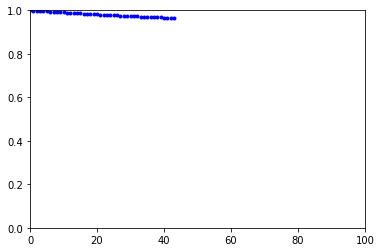

In [77]:
sgd_sequence = nn_stochastic_gradient_descent_sequence(
                    weights,
                    batch_generator(MNIST_data_stream, batch_size),
                    learning_rate = learning_rate,
                    cost_derivative = cross_entropy_cost_derivative)

%matplotlib inline
import time
from IPython import display
import matplotlib.pyplot as plt
stride = 1
max_iter = 10**2
y_max = 1
for i, weights in enumerate(
                    islice(
                        sgd_sequence,
                        0, max_iter, stride)):
    e = batch_error(MNIST_test_data[:100], weights)
    if i == 0:
        y_max = e
    #plt.clf()
    plt.plot(i*stride, e, 'b.')
    plt.xlim(0, max_iter)
    #plt.ylim(0, y_max)
    plt.ylim(0, 1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
#weights = next(sgd_sequence)

In [73]:
batch_generator

<function more_itertools.more.chunked(iterable, n, strict=False)>

In [80]:
sgd_seq = nn_stochastic_gradient_descent_sequence(
        weights,
        batch_generator(MNIST_data_stream, batch_size),
        learning_rate = learning_rate,
        cost_derivative = cross_entropy_cost_derivative)
for i in range(4):
    print(partial(batch_error, MNIST_test_data[:100])(next(sgd_seq)))

0.9646761305198625
0.9640561064030005
0.9634391262399656
0.9627954629397156


In [83]:
test = filter_max_iter(10)(nn_stochastic_gradient_descent_sequence(
        weights,
        batch_generator(MNIST_data_stream, batch_size),
        learning_rate = learning_rate,
        cost_derivative = cross_entropy_cost_derivative))

In [84]:
for t in test:
    print(partial(batch_error, MNIST_test_data[:100])(t))

0.9646761305198625
0.9640840800438828
0.9633833203290183
0.9627094723824651
0.9620405896704094
0.9613351857604526
0.9606665852347175
0.9600971714746368
0.959453353490375
0.9588272546147433


In [68]:
test = list(filter_max_iter(10)(
            nn_stochastic_gradient_descent_sequence(
                weights,
                batch_generator(MNIST_data_stream, batch_size),
                learning_rate = learning_rate,
                cost_derivative = cross_entropy_cost_derivative)))

In [72]:
partial(batch_error, MNIST_test_data[:100])(test[0])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 784)

In [88]:
evaluate_vs_testing_data = partial(batch_error, MNIST_test_data[:100])

errors = pipeline_eval(
    nn_stochastic_gradient_descent_sequence(
        weights,
        batch_generator(MNIST_data_stream, batch_size),
        learning_rate = learning_rate,
        cost_derivative = cross_entropy_cost_derivative),
    partial(map, evaluate_vs_testing_data),
    filter_max_iter(10**2),
    list)

In [89]:
errors[:5]

[0.9646761305198625,
 0.9640585930478918,
 0.9634055838164416,
 0.9627506025230287,
 0.9621594606878134]

In [113]:
batch_error(test, MNIST_test_data)

0.9058550432440848

In [45]:
test_batch_generator = batch_generator(MNIST_data_stream, 5)
batch = next(test_batch_generator)

In [48]:
my_sgd = nn_gradient_descent_sequence(
                        weights, 
                        batch, 
                        learning_rate = learning_rate)

In [50]:
next(my_sgd)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in cosh


TypeError: object of type 'itertools.islice' has no len()

In [40]:
weights = next(sgd_sequence)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in cosh


ValueError: last() was called on an empty iterable, and no default was provided.

In [7]:
from math import sin

In [16]:
ϵ = 1e-10
x = 1
y = x - ϵ

In [17]:
val1 = sin(x) - sin(y)
print(val1)
val2 = sin(x)*(1-sin(x)/sin(y))
print(val2)

5.403022473871033e-11
-5.403026672509223e-11


In [18]:
val1 - val2

1.0806049146380257e-10